# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**:
*   Your **student number**: 



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

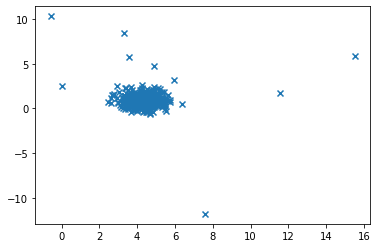

In [0]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x")
plt.show()

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X, axis = 0)
    mu = sum_/m
    
    # compute variance of X
    var = (np.sum((X - mu)**2, axis = 0))/m
    
    return mu,var
mu, sigma = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    
    return p
p = multivariateGaussian(X, mu, sigma)

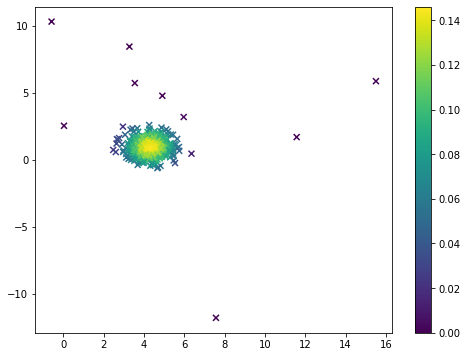

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.02

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

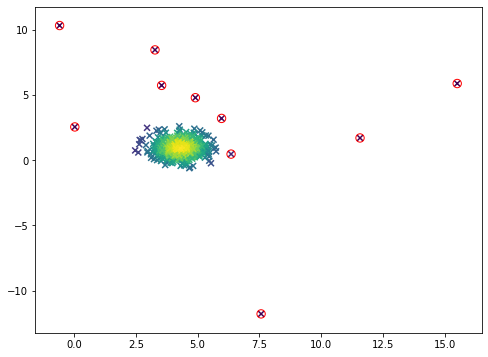

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the **highest** value of K for which we get precision of 1.0? 
> The highest value of k is 10
* What is the precision and recall for K=4? 
> Precision: 1, Recall: 0.4

In [0]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# Assuming 1 is anomaly and 0 is not anomaly

def sort_and_predict(p, y_true, K = [1,10,100]):
    # Initializing values
    precision_scores = np.zeros((len(K),3)) # Final Table of precision/recall scores

    # Storing the indices of the sorted p
    sorted_indices = np.argsort(p)

    # Sorting the probabilities in ascending order
    sorted_p = np.sort(p)

    # Sorting the predictions according to probabilities
    sorted_y_true = y_true[sorted_indices]

    # Looping through k
    for count, k in enumerate(K):
        y_pred = np.zeros((len(p),)) # Generating a prediction vector
        y_pred[:k] = 1 # Anomaly
        y_pred[k:] = 0 # Not anomaly
        precision_scores[count,0] = k
        precision_scores[count,1] = precision_score(sorted_y_true, y_pred)
        precision_scores[count,2] = recall_score(sorted_y_true, y_pred)

    return pd.DataFrame(precision_scores, columns = ['k','Precision','Recall']).set_index('k')

sort_and_predict(p, y_true, K = list(range(1,100)))  

,Precision,Recall
k,,
1.0,1.000000,0.1
2.0,1.000000,0.2
3.0,1.000000,0.3
4.0,1.000000,0.4
5.0,1.000000,0.5
...,...,...
95.0,0.105263,1.0
96.0,0.104167,1.0
97.0,0.103093,1.0


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

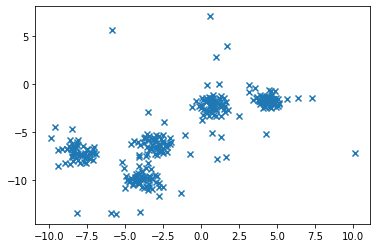

In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x")
plt.show()

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision and recall for k=1 in the cell below?
> Precision: 1, Recall: 0.055
* k=10? 
> Precision: 0.9, Recall: 0.50
* k=100? 
> Precision: 0.13, Recall: 0.72

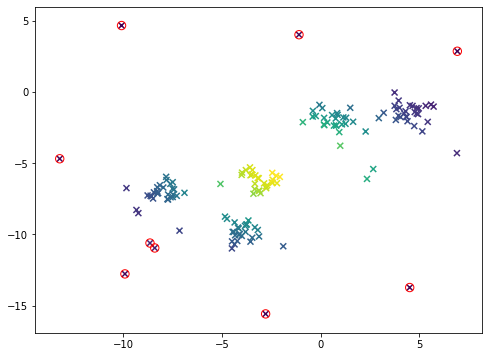

In [0]:
mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);


In [0]:
sort_and_predict(p, y_test, K = [1,10,100])

,Precision,Recall
k,,
1.0,1.00,0.055556
10.0,0.90,0.500000
100.0,0.13,0.722222


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [0]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

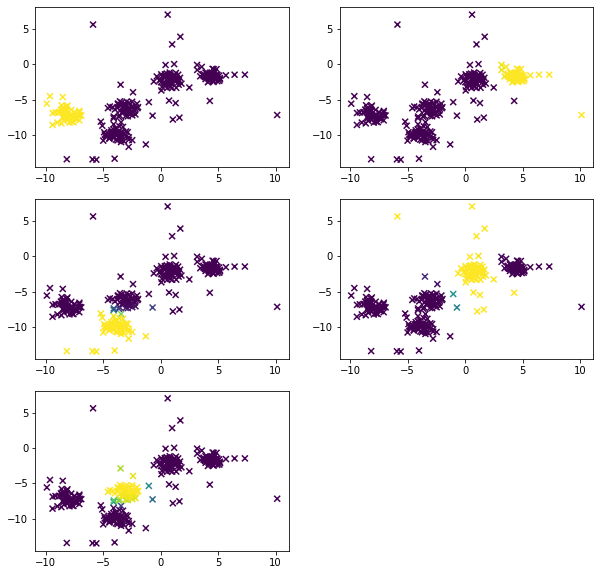

In [0]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision and recall @k for k=1, 10, and 100.

* Is this model better or worse performing than the previous?
> It performs better
* Why might that be?
> The data is clustered and so you cannot fit one normal distribution to it. We need a mixture of many Guassians to fit the clusters and so Mixture of Gaussians method works better. Each cluster will get a normal distribution and so we can calculate the probablity that a point is outside all of the clusters. If we fit a single Gaussian, we might predict points between clusters to not be anomalous because we're only fit clustered data to one distribution. 

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


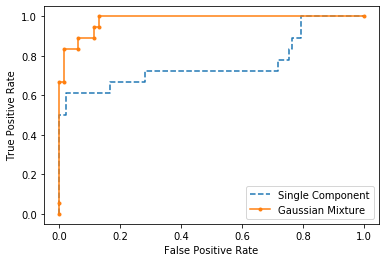

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

In [0]:
sort_and_predict(p_gm, y_test, K = [1,10,100])

,Precision,Recall
k,,
1.0,1.00,0.055556
10.0,1.00,0.555556
100.0,0.18,1.000000


Although our MoG model doesn't perfectly identify all the outliers, it performs way better than our previous model, again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [0]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2019-12-06 12:00:11--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-12-06 12:00:11--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle’

simpsons.pickle     100%[===================>]  25.46K  --.-KB/s    in 0.006s  

2019-12-06 12:00:11 (3.87 MB/s) - ‘simpsons.pickle’ saved [26076/26076]



In [0]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))

With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating?
> 7.1
* What is the range of ratings? 
> 5.3

In [0]:
# Extracting ratings into a nunmpy array
ratings = np.array([])
for value in simpsons.values():
  ratings = np.append(ratings, list(value.values()))

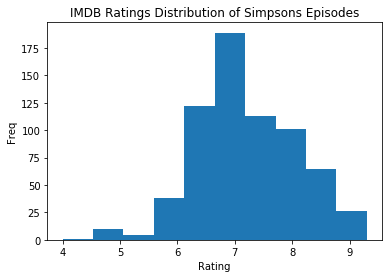

Modal Rating: 7.1
Range of Ratings: 5.300000000000001


In [0]:
from scipy.stats import mode

fig = plt.hist(ratings)
plt.title('IMDB Ratings Distribution of Simpsons Episodes')
plt.xlabel('Rating')
plt.ylabel('Freq')
plt.show()

print("Modal Rating:", mode(ratings)[0][0])
print("Range of Ratings:", ratings.max() - ratings.min())

Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model?
> Bad: 6.7734211, Good: 8.17942889
* What about the standard deviations?
> Bad: 0.59689303, Good: 0.4741226

In [0]:
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gm.fit(ratings.reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
print("Means:",gm.means_[:,0])
print("Standard Deviations:", np.sqrt(gm.covariances_[:,0][:,0]))

Means: [6.7734211  8.17942889]
Standard Deviations: [0.59689303 0.4741226 ]


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point?
> Season 9
* When is the first season with 0 good episodes?
> Season 15

In [0]:
for season, episodes in simpsons.items():
  for episode, rating in episodes.items():
    simpsons[season][episode] = gm.predict(np.array(rating).reshape(-1,1))[0]

In [0]:
simpsons_df = pd.DataFrame(simpsons)
summary = simpsons_df.apply(pd.Series.value_counts).fillna(0)
summary.columns = pd.MultiIndex.from_tuples(list(zip(['Season']*32, list(range(1,33)))))
print("Number of Good (1) and Bad Episodes (0) Per Season:")
display(summary)

Number of Good (1) and Bad Episodes (0) Per Season:


Season                            ...                                    
        1   2     3   4   5   6   7   ...  26  27    28    29    30   31   32
0.0      4   4   0.0   1   1   1   1  ...  21  21  21.0  21.0  23.0  7.0  1.0
1.0      9  18  24.0  21  21  24  24  ...   1   1   0.0   0.0   0.0  0.0  0.0

[2 rows x 32 columns]

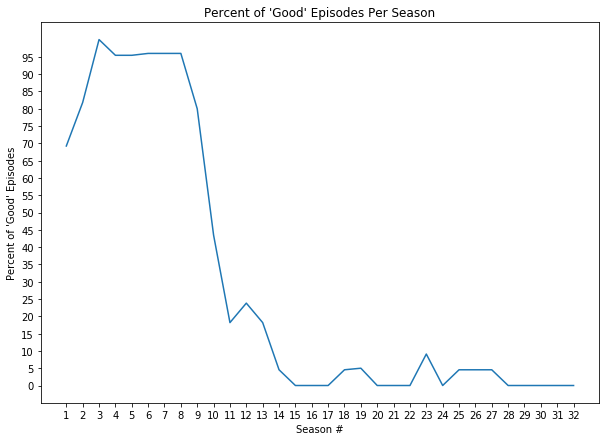

In [0]:
fig = plt.figure(figsize=(10, 7))
plt.xticks(np.arange(1,33))
plt.yticks(np.arange(0,100,5))
plt.plot(summary.columns.get_level_values(1) , summary.iloc[1,:]*100/(summary.iloc[1,:] + summary.iloc[0,:]))
plt.title("Percent of 'Good' Episodes Per Season")
plt.xlabel("Season #")
plt.ylabel("Percent of 'Good' Episodes")
plt.show()

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1]
> 284,807 rows
* What features in the dataset are present aside from the 28 main features?[1]
> Time, Amount
* Why do you think the main features are given to us in this way?[1]
> The features were generated from a PCA analysis. The features are given to us in this way because they might contain confidential information about a transaction which we shouldn't be able to see. Also, there could have been a lot of different features (perhaps 1000s of features) which they did a PCA analysis on to convert it to a smaller feature set, so making it easier to distribute, analyze and visualize while keeping user/transaction data private (we won't know what the PCA transformed features directly represent). 
* Which column contains the targets? Can you figure out what the values correspond to?[1] 
> Class Column contains the targets. 0 is non fradulent, 1 is fradulent - this can be inferred by simply looking at the value counts. Fradulence should be less likely

In [0]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=9a0605beb5ed960e33f7e4f6c356df6f4cf222a432eb43623bfeb8b3ec325b63
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [0]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
cc_df = pd.read_csv('creditcard.csv')

In [0]:
print(cc_df.head())
print("Rows:", cc_df.shape[0])
print(cc_df.columns)
print(cc_df['Class'].value_counts())

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]
Rows: 284807
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
0    284315
1       492
Name: Class, dtype: int64


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] 
> 99.83% non-fradulent, 0.17% fradulent
* Why might this pose a problem with methods we have looked at so far?[1]
> There are not enough fradulent examples. Data is not equally distributed between fradulent and non-fradulent. This might make it difficult to split the dataset into train and test and have a reasonable amount of fradulent examples in each set for our model to identify fraudulent examples easily. 



In [0]:
print(cc_df['Class'].value_counts()*100/cc_df.shape[0])

0    99.827251
1     0.172749
Name: Class, dtype: float64


Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1]
> Mean: 0.000429 <br> Standard Deviation: 0.605




Use the code below to set up a Gaussian object for V24.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cc_df.iloc[:,0:-1], cc_df['Class'], test_size = 1/3, random_state = 0, shuffle = True)

In [0]:
print("Mean:",X_train['V24'].mean())
print("Standard Dev:", X_train['V24'].std())

Mean: 0.00042967016116414686
Standard Dev: 0.6048294388274841


In [0]:
from scipy import stats

norm = stats.norm(
    loc = X_train['V24'].mean(),
    scale = X_train['V24'].std()
)

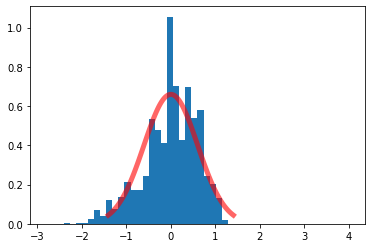

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

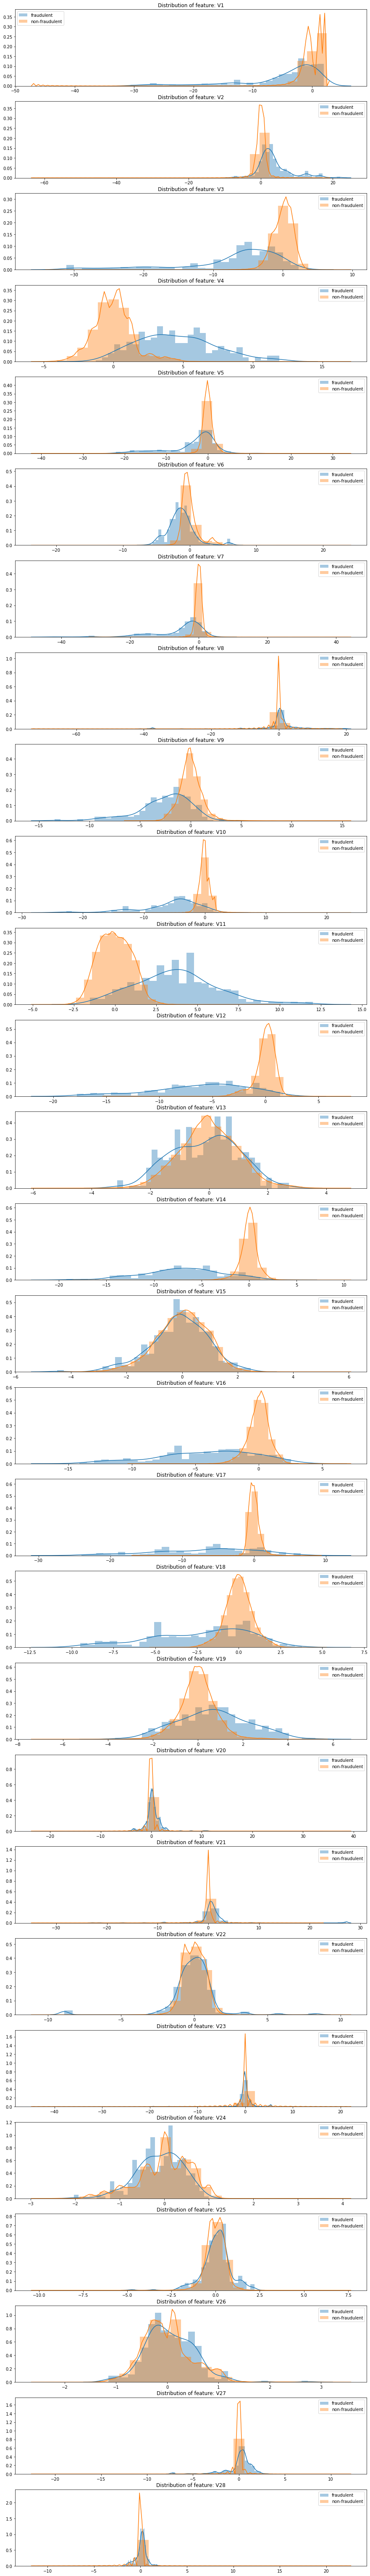

In [0]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in cc_df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report the precision and recall@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

### Building the Model

#### Feature Picking:

I picked the following features:
- V4
- V11
- V12
- V14
- V16
- V17

I chose these features to start with because these features had minimal histogram overlap between fraudulent versus not fraudulent data.

#### Useful Function

In [0]:
import matplotlib.pyplot as plt

# Function to test different hyperparameters
def model_selection_process(cc_df, compare, n_components, features_selected, random_state = 0, ks_tested = [1, 5, 10, 15, 25, 50, 75, 100]):
  fig = plt.figure(figsize=(20,15))
  fig, ax_lst = plt.subplots(1, 2)
  
  final = pd.DataFrame()
  
  if compare == "n":
    for n in n_components:
      X_train, X_test, y_train, y_test = train_test_split(cc_df[features_selected], cc_df['Class'], train_size = 2/3, random_state=random_state)
      gm = GaussianMixture(n_components = n, covariance_type = 'full', random_state=random_state)
      gm.fit(X_train)
      p_gm = gm.score_samples(X_test)
      test = sort_and_predict(p_gm, np.array(y_test), K = ks_tested )
      ax_lst[0].plot(test['Precision'], label = f"n = {n}")
      ax_lst[1].plot(test['Recall'], label = f"n = {n}")
      test.columns = pd.MultiIndex.from_tuples([(f"n_components = {n}", "Precision"), (f"n_components = {n}", "Recall")])
      final = pd.concat([final,test], axis = 1)
    ax_lst[0].legend()
    ax_lst[1].legend()
    ax_lst[0].title.set_text("Precision Versus K")
    ax_lst[1].title.set_text("Recall Versus K")
    ax_lst[0].set_ylim([0,1])
    ax_lst[1].set_ylim([0,1])
    fig.suptitle(f"Features Selected: {features_selected}")
  
  elif compare == "features":
    for features in features_selected:
      X_train, X_test, y_train, y_test = train_test_split(cc_df[features], cc_df['Class'], train_size = 2/3, random_state=random_state)
      gm = GaussianMixture(n_components = n_components, covariance_type = 'full', random_state=random_state)
      gm.fit(X_train)
      p_gm = gm.score_samples(X_test)
      test = sort_and_predict(p_gm, np.array(y_test), K = ks_tested)
      ax_lst[0].plot(test['Precision'], label = f"feature_set = {features}")
      ax_lst[1].plot(test['Recall'], label = f"feature_set = {features}")
      test.columns = pd.MultiIndex.from_tuples([(f"features = {features}", "Precision"), (f"features = {features}", "Recall")])
      final = pd.concat([final,test], axis = 1)
    ax_lst[0].legend()
    ax_lst[1].legend()
    ax_lst[0].title.set_text("Precision Versus K")
    ax_lst[1].title.set_text("Recall Versus K")
    ax_lst[0].set_ylim([0,1])
    ax_lst[1].set_ylim([0,1])
    fig.suptitle(f"N_Components Selected: {n_components}")   
    
  return fig, final.loc[[1,10,100], :]

#### Iteration 1: Varying N Components for a Fixed Feature Set (['V4','V11','V12','V14','V16','V17'])

<Figure size 1440x1080 with 0 Axes>

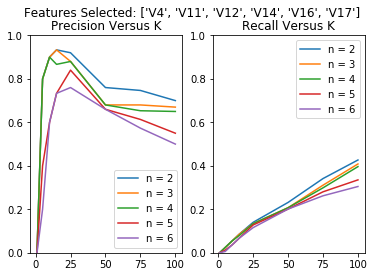

In [0]:
iteration1, table1 = model_selection_process(cc_df,  compare = "n", n_components = [2,3,4,5,6], features_selected = ['V4','V11','V12','V14','V16','V17'])

In [0]:
display(table1)

n_components = 2            ... n_components = 6          
           Precision    Recall  ...        Precision    Recall
k                               ...                           
1                0.0  0.000000  ...              0.0  0.000000
10               0.9  0.054878  ...              0.6  0.036585
100              0.7  0.426829  ...              0.5  0.304878

[3 rows x 10 columns]

Based on my first iteration, performance (in terms of precision and recall) improves as we decrease the number of components. Furthermore, it seems like n=2 performs best for precision and recall because the graph is equal to or higher than all the other choices for n_components.

What I noticed in the histograms earlier was that V4 and V11 had similar distributions (fradulent data to the right of non-fradulent) while V12, V14, V16, V17 had similar distributions (fraduelent data to the left of nan-fraudulent). It would be interesting to compare the [V4, V11] pair to the [V12, V14, V16, V17] pair for the next iteration for n = 2.

#### Iteration 2: Varying Feature Sets for 2 Components Based on Relative Locations of Fradulent Versus Non-Fradulent Distributions

<Figure size 1440x1080 with 0 Axes>

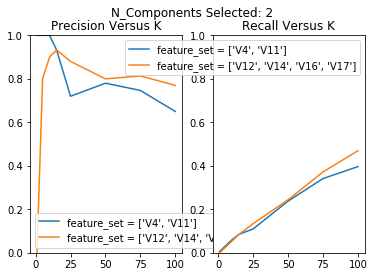

In [0]:
iteration2, table2 = model_selection_process(cc_df, features_selected = [['V4', 'V11'],['V12', 'V14', 'V16', 'V17']], n_components = 2, compare = 'features')

In [0]:
display(table2)

features = ['V4', 'V11']  ... features = ['V12', 'V14', 'V16', 'V17']
                   Precision  ...                                  Recall
k                             ...                                        
1                       1.00  ...                                0.000000
10                      1.00  ...                                0.054878
100                     0.65  ...                                0.469512

[3 rows x 4 columns]

We notice that having fradulent data to the right of non-fradulent (V4,V11) performs almost equal to or worse than having fradulent data to the left of non-fradulent (V12, V14, V16, V17) in terms of recall for all k values tested. 

In terms of precision, low values of k have a much higher precision when using the V4, V11 feature set, but this changes as k increases. 

Also, we notice that precision is much higher than recall on average. Hence, we need to focus a bit more on choosing our model to maximize recall because we want to be able to correctly predict fradulent cases.

Hence, it seems like V12, V14, V16, V17 pair would be the better option to continue with at this stage.

It would be interesting to remove V16 and V17 because they show a lot more overlap than V12 and V14. We can compare them on the next iteration for n = 2

#### Iteration 3: Comparing Feature Sets Based On Overlap of Fradulent Versus Non-Fradulent Cases

<Figure size 1440x1080 with 0 Axes>

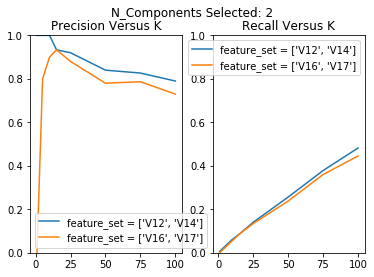

In [0]:
iteration3, table3 = model_selection_process(cc_df, compare = "features", n_components = 2, features_selected = [['V12', 'V14'], ['V16', 'V17']])

In [0]:
display(table3)

features = ['V12', 'V14']           features = ['V16', 'V17']          
                    Precision    Recall                 Precision    Recall
k                                                                          
1                        1.00  0.006098                      0.00  0.000000
10                       1.00  0.060976                      0.90  0.054878
100                      0.79  0.481707                      0.73  0.445122

V12, V14 feature set performs approximately equal to or better than the V16, V17 feature set on both precision and recall for all k values tested. Hence, we will continue with the V12, V14 feature set.

We will finally test this for 1, 2, 3 and 4 components because there were some similarities in performance earlier for different values of n_components, particularly 2 or 3 components. We'll also look at 1 component because we overlooked that in the earlier iterations.

#### Iteration 4: Comparing a Few More Values of N_Components

<Figure size 1440x1080 with 0 Axes>

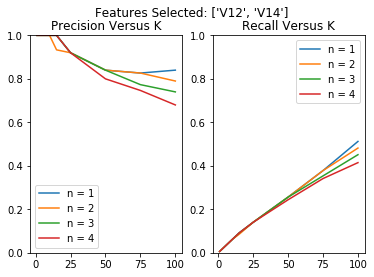

In [0]:
iteration4, table4 = model_selection_process(cc_df, compare = "n", n_components = [1,2,3,4], features_selected = ['V12', 'V14'])

In [0]:
display(table4)

n_components = 1            ... n_components = 4          
           Precision    Recall  ...        Precision    Recall
k                               ...                           
1               1.00  0.006098  ...             1.00  0.006098
10              1.00  0.060976  ...             1.00  0.060976
100             0.84  0.512195  ...             0.68  0.414634

[3 rows x 8 columns]

In terms of recall, we see that 1 or 2 components performs approximately equal to or better than 3 or 4 components, particularly as k increases. In terms of precision, 1 or 2 components start off worse but then perform better. 

n_components=1 performs better than n_components=2 particularly as k increases. Hence, we will go with n_components=1

#### Final Model Performance

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cc_df[['V12','V14']], cc_df['Class'], train_size = 2/3, random_state=0)
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train)
p_gm = gm.score_samples(X_test)
test = sort_and_predict(p_gm, np.array(y_test), K = [1, 5, 10, 15, 25, 50, 75, 100])

In [0]:
display(test.loc[[1,10,100]])

,Precision,Recall
k,,
1,1.00,0.006098
10,1.00,0.060976
100,0.84,0.512195


For the feature pair V12-V14, we get a max recall of 0.51 at k=100. For this k value, the precision is 0.84. There's definitely a lot more we can do to improve the result. That would involve obtaining more examples of fraudulent cases to train our model. We could also experiment with other feature sets.

Ultimately, lower number of components, less overlapped distributions work best.